In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import  train_test_split
import copy
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from skopt.space import Real, Integer, Categorical
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import learning_curve

In [2]:
failures = pd.read_csv('../data/model_data/failures.csv',sep=',')
components = failures['Component'].unique()

In [3]:
encoder = LabelEncoder()
for component in components:
    globals()[f"{component}_df"] = pd.read_csv(f'../data/model_data/labelled_data_{component}.csv',sep=',')
    globals()[f"{component}_df"]['Turbine_ID'] = encoder.fit_transform(['Turbine_ID']*globals()[f"{component}_df"].shape[0])
    # set the date as the index
    globals()[f"{component}_df"] = globals()[f"{component}_df"].set_index('Timestamp')

In [5]:
class_target_name = "Failure (Target)"
for component in components:
    X = globals()[f"{component}_df"].drop(columns=['Component',class_target_name])
    y = globals()[f"{component}_df"][class_target_name]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    globals()[f"{component}_X_train"] = X_train
    globals()[f"{component}_X_test"] = X_test
    globals()[f"{component}_y_train"] = y_train
    globals()[f"{component}_y_test"] = y_test

In [6]:
model_name = "xgb"

In [7]:
for component in components:

    with open("./model/{}_{}.pickle".format(model_name, component), "rb") as f:
        globals()[f"{model_name}_{component}"] = pickle.load(f)

In [10]:
def train_run(X, y, X_valid, y_valid, model):
    clf = model
    clf.fit(X, y)
    y_valid_pred = clf.predict(X_valid)
    y_train_pred = clf.predict(X)
    f1_train = f1_score(y, y_train_pred, average="weighted")
    precision_train = precision_score(y, y_train_pred, average="weighted")
    recall_train = recall_score(y, y_train_pred, average="weighted")
    f1 = f1_score(y_valid, y_valid_pred, average="weighted")
    precision = precision_score(y_valid, y_valid_pred, average="weighted")
    recall = recall_score(y_valid, y_valid_pred, average="weighted")

    scores = {
        "f1_train": f1_train,
        "precision_train": precision_train,
        "recall_train": recall_train,
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }

    return scores

In [21]:
def train_runs_XGB(X_train, y_train, model):
    clf = ExtraTreesClassifier(n_estimators=50)
    tree_selector = SelectFromModel(clf)
    univariate_selector1 = SelectKBest(f_classif, k=3)
    univariate_selector2 = SelectKBest(f_classif, k=6)
    univariate_selector3 = SelectKBest(f_classif, k=7)
    base_estimator = model
    base_estimator.steps.insert(-1, ["selector", tree_selector])
    param_grid = {
   
        "selector": Categorical(["passthrough", tree_selector, univariate_selector1, univariate_selector2, univariate_selector3]),
        "{}__max_depth".format(model_name): [10, 20, 40, 80],
        "{}__n_estimators".format(model_name): [50, 100, 200],
        "{}__learning_rate".format(model_name): Real(0.01, 0.2, prior='log-uniform')

    }
    bayes_search = BayesSearchCV(
        estimator=base_estimator,
        search_spaces=param_grid,
        scoring="f1_weighted",
        n_iter=50,
        cv=5,
        verbose=2,
        random_state=0,
        n_jobs=-1
    )

    bayes_search.fit(X_train, y_train)
    results = bayes_search.cv_results_
    best_clf = bayes_search.best_estimator_

    return best_clf, results, param_grid

In [ ]:
for component in components:
    # get the best model
    globals()[f"{component}_best_clf"], globals()[f"{component}_results"], globals()[f"{component}_param_grid"] = train_runs_XGB(globals()[f"{component}_X_train"], globals()[f"{component}_y_train"], globals()[f"{model_name}_{component}"])


In [28]:
for component in components:
    globals()[f"{component}_scores"] = train_run(globals()[f"{component}_X_train"], globals()[f"{component}_y_train"], globals()[f"{component}_X_test"], globals()[f"{component}_y_test"], globals()[f"{component}_best_clf"])


/Users/supriyasindigerekumaraswmamy/Desktop/Thesis/wind_Turbine/venv/lib/python3.12/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/supriyasindigerekumaraswmamy/Desktop/Thesis/wind_Turbine/venv/lib/python3.12/site-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/Users/supriyasindigerekumaraswmamy/Desktop/Thesis/wind_Turbine/venv/lib/python3.12/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/supriyasindigerekumaraswmamy/Desktop/Thesis/wind_Turbine/venv/lib/python3.12/site-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


In [29]:
for component in components:
    print(f"{component} scores:")
    print(globals()[f"{component}_scores"])

GEARBOX scores:
{'f1_train': 1.0, 'precision_train': 1.0, 'recall_train': 1.0, 'f1': 0.9303256667806926, 'precision': 0.9421826774146138, 'recall': 0.9493844049247606}
GENERATOR scores:
{'f1_train': 1.0, 'precision_train': 1.0, 'recall_train': 1.0, 'f1': 0.9167371897156757, 'precision': 0.9197284339846512, 'recall': 0.9261285909712722}
HYDRAULIC_GROUP scores:
{'f1_train': 1.0, 'precision_train': 1.0, 'recall_train': 1.0, 'f1': 0.9008683604310944, 'precision': 0.8986199824261317, 'recall': 0.908344733242134}
GENERATOR_BEARING scores:
{'f1_train': 1.0, 'precision_train': 1.0, 'recall_train': 1.0, 'f1': 0.9560207564166, 'precision': 0.9550757254531023, 'recall': 0.9616963064295485}
TRANSFORMER scores:
{'f1_train': 1.0, 'precision_train': 1.0, 'recall_train': 1.0, 'f1': 0.9416218828289623, 'precision': 0.9415913644058822, 'recall': 0.9466484268125855}


In [ ]:
for component in components:
   #print best clf
    print(f"{component} best clf:")
    print(globals()[f"{component}_best_clf"])

In [30]:
for component in components:
    
    globals()[f"{component}_y_pred_train"] = globals()[f"{component}_best_clf"].predict(globals()[f"{component}_X_train"])
    globals()[f"{component}_y_pred_test"] = globals()[f"{component}_best_clf"].predict(globals()[f"{component}_X_test"])



In [31]:
def compute_rates(confusion_matrix):
    FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
    FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
    TP = np.diag(confusion_matrix)
    TN = confusion_matrix.sum() - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP / (TP + FN)
    # Specificity or true negative rate
    TNR = TN / (TN + FP)
    # Precision or positive predictive value
    PPV = TP / (TP + FP)
    # Negative predictive value
    NPV = TN / (TN + FN)
    # Fall out or false positive rate
    FPR = FP / (FP + TN)
    # False negative rate
    FNR = FN / (TP + FN)
    # False discovery rate
    FDR = FP / (TP + FP)

    return {
        "tpr": TPR,
        "tnr": TNR,
        "ppv": PPV,
        "npv": NPV,
        "fpr": FPR,
        "fnr": FNR,
        "fdr": FDR,
    }

In [32]:
# Confusion matrix for each component
for component in components:
    globals()[f"{component}_confusion_matrix_train"] = confusion_matrix(globals()[f"{component}_y_train"], globals()[f"{component}_y_pred_train"])
    globals()[f"{component}_confusion_matrix_test"] = confusion_matrix(globals()[f"{component}_y_test"], globals()[f"{component}_y_pred_test"])

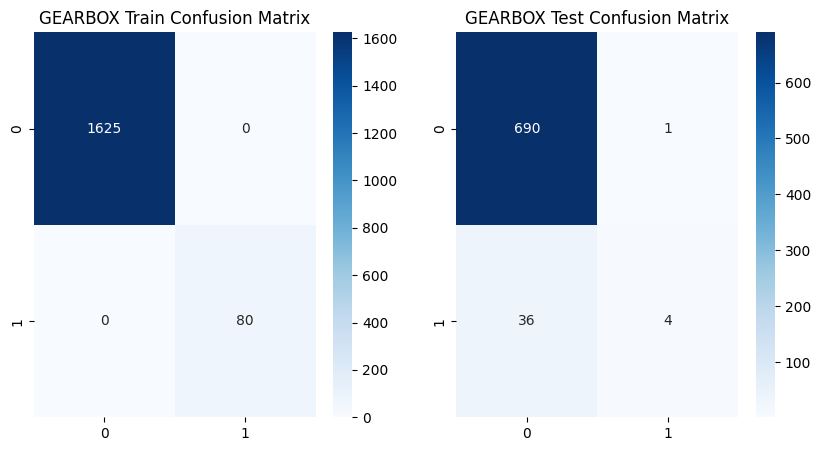

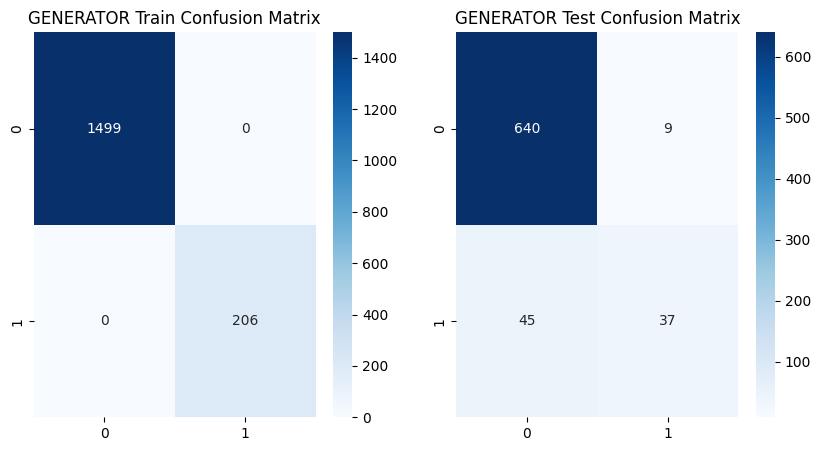

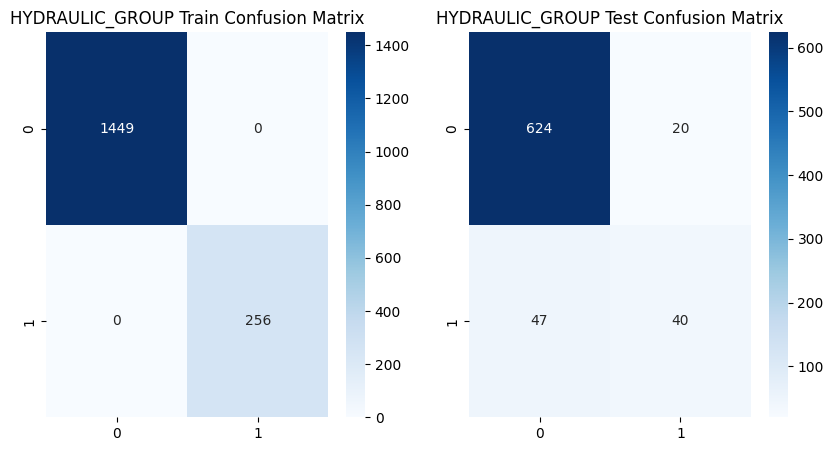

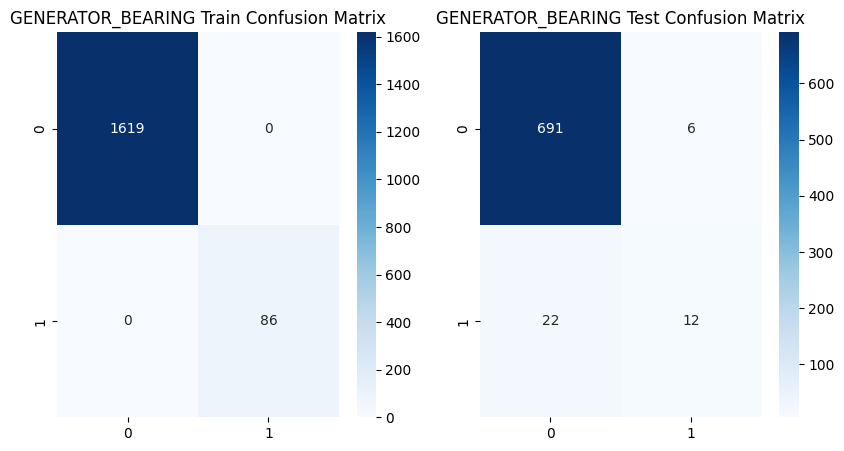

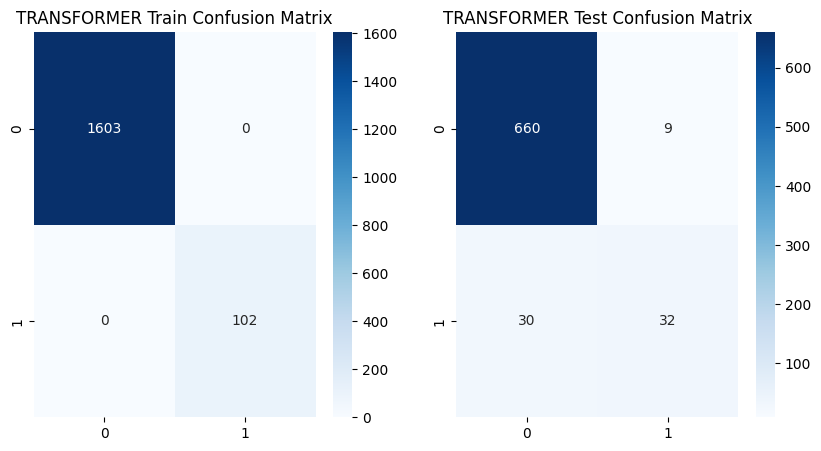

In [33]:
# Plot the confusion matrix
for component in components:
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.heatmap(globals()[f"{component}_confusion_matrix_train"], annot=True, fmt="d", cmap="Blues", ax=ax[0])
    ax[0].set_title(f"{component} Train Confusion Matrix")
    sns.heatmap(globals()[f"{component}_confusion_matrix_test"], annot=True, fmt="d", cmap="Blues", ax=ax[1])
    ax[1].set_title(f"{component} Test Confusion Matrix")
    plt.show()

In [35]:
for component in components:

    globals()[f"{component}_train_size_abs"], globals()[f"{component}_train_scores"], globals()[f"{component}_test_scores"] = learning_curve(
        globals()[f"{component}_best_clf"], globals()[f"{component}_X_train"], globals()[f"{component}_y_train"], scoring="f1_weighted"
    )


/Users/supriyasindigerekumaraswmamy/Desktop/Thesis/wind_Turbine/venv/lib/python3.12/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/supriyasindigerekumaraswmamy/Desktop/Thesis/wind_Turbine/venv/lib/python3.12/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/supriyasindigerekumaraswmamy/Desktop/Thesis/wind_Turbine/venv/lib/python3.12/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/supriyasindigerekumaraswmamy/Desktop/Thesis/wind_Turbine/venv/lib/python3.12/site-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/Users/supriyasindigerekumaraswmamy/Desktop/Thesis/wind_Turbine/venv/lib/python3.12/site-packages/numpy/core/_methods.py:176: RuntimeWarning

In [36]:
my_lc = []
for component in components:
    for train_size, cv_train_scores, cv_test_scores in zip(globals()[f"{component}_train_size_abs"], globals()[f"{component}_train_scores"], globals()[f"{component}_test_scores"]):
            my_lc.append(
        {
            "n": int(train_size),
            "train_score": cv_train_scores.mean(),
            "test_score": cv_test_scores.mean(),
        }
    )
            
my_lc

[{'n': 136, 'train_score': 1.0, 'test_score': 0.9331578273858128},
 {'n': 443, 'train_score': 1.0, 'test_score': 0.9359160260002266},
 {'n': 750, 'train_score': 1.0, 'test_score': 0.9361910348966933},
 {'n': 1057, 'train_score': 1.0, 'test_score': 0.9390667891389561},
 {'n': 1364, 'train_score': 1.0, 'test_score': 0.9443153930228132},
 {'n': 136, 'train_score': 1.0, 'test_score': 0.8435316838419844},
 {'n': 443, 'train_score': 1.0, 'test_score': 0.8542936879780362},
 {'n': 750, 'train_score': 1.0, 'test_score': 0.8838426456285875},
 {'n': 1057, 'train_score': 1.0, 'test_score': 0.8939289934120985},
 {'n': 1364, 'train_score': 1.0, 'test_score': 0.9041325031992151},
 {'n': 136, 'train_score': 1.0, 'test_score': 0.7860689788912557},
 {'n': 443, 'train_score': 1.0, 'test_score': 0.8069279879174849},
 {'n': 750, 'train_score': 1.0, 'test_score': 0.8321197213538634},
 {'n': 1057, 'train_score': 1.0, 'test_score': 0.8329553000693964},
 {'n': 1364, 'train_score': 1.0, 'test_score': 0.84550805

In [37]:
import pickle
import os

In [38]:
for component in components:
    with open("./model/selected-{}_{}.pickle".format(model_name, component), "wb") as handle:
        handle.write(pickle.dumps(globals()[f"{component}_best_clf"]))